Train#=181937 Test#=77973
Labels=[np.float64(0.0), np.float64(1.0)]
RF best for 500 trees (d=7 and f=0.5)


<Figure size 600x450 with 0 Axes>

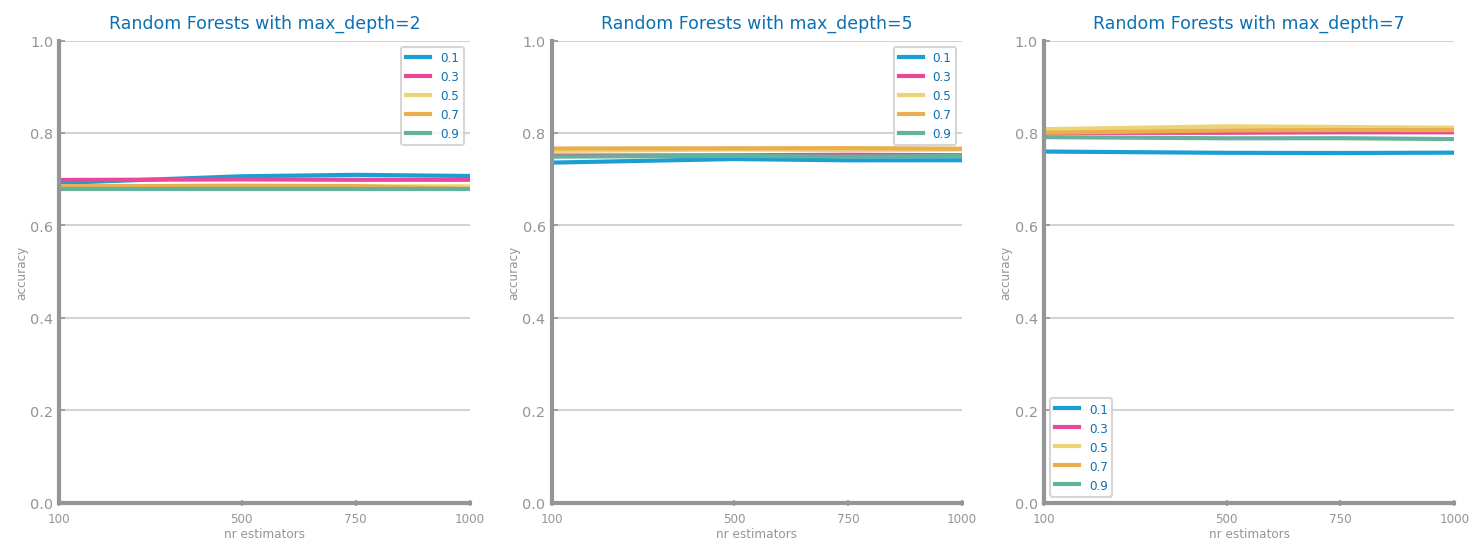

In [7]:
from numpy import array, ndarray
from matplotlib.pyplot import subplots, figure, savefig, show
from sklearn.ensemble import RandomForestClassifier
from dslabs_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from dslabs_functions import HEIGHT, plot_evaluation_results, plot_multiline_chart


def random_forests_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_trees: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[RandomForestClassifier | None, dict]:
    n_estimators: list[int] = [100] + [i for i in range(500, nr_max_trees + 1, lag)]
    max_depths: list[int] = [2, 5, 7]
    max_features: list[float] = [0.1, 0.3, 0.5, 0.7, 0.9]

    best_model: RandomForestClassifier | None = None
    best_params: dict = {"name": "RF", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}

    cols: int = len(max_depths)
    _, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    for i in range(len(max_depths)):
        d: int = max_depths[i]
        values = {}
        for f in max_features:
            y_tst_values: list[float] = []
            for n in n_estimators:
                clf = RandomForestClassifier(
                    n_estimators=n, max_depth=d, max_features=f
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (d, f, n)
                    best_model = clf
                # print(f'RF d={d} f={f} n={n}')
            values[f] = y_tst_values
        plot_multiline_chart(
            n_estimators,
            values,
            ax=axs[0, i],
            title=f"Random Forests with max_depth={d}",
            xlabel="nr estimators",
            ylabel=metric,
            percentage=True,
        )
    print(
        f'RF best for {best_params["params"][2]} trees (d={best_params["params"][0]} and f={best_params["params"][1]})'
    )
    return best_model, best_params


file_tag = "JURISDICTION_CODE"
train_filename = "/home/mina/Documents/portugal/dataScience/train_dataset_1.csv"
test_filename = "/home/mina/Documents/portugal/dataScience/test_dataset_1.csv"
target = "JURISDICTION_CODE"
eval_metric = "accuracy"

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target
)
print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

figure()
best_model, params = random_forests_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_trees=1000,
    lag=250,
    metric=eval_metric,
)
savefig(f"/home/mina/Documents/portugal/dataScience/Data_science_project/classification/image2/{file_tag}_rf_{eval_metric}_study.png")
show()

<Figure size 600x450 with 0 Axes>

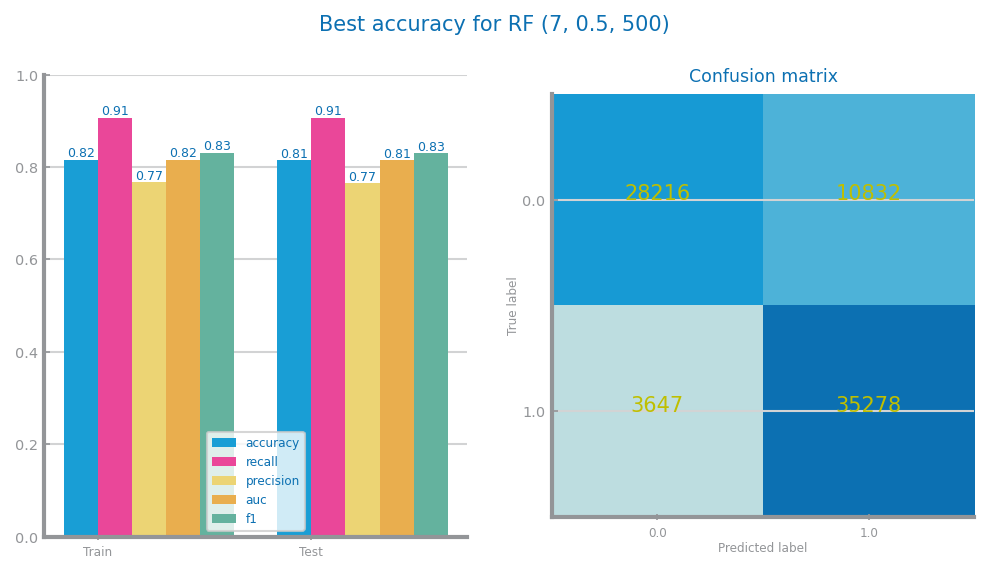

In [8]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'/home/mina/Documents/portugal/dataScience/Data_science_project/classification/image2/{file_tag}_rf_{params["name"]}_best_{params["metric"]}_eval.png')
show()

1. ARREST_PRECINCT (0.2014526403532788)
2. PD_CD (0.15817792658156504)
3. Latitude (0.14792201274589092)
4. Y_COORD_CD (0.12572506367232641)
5. X_COORD_CD (0.1183595437332041)
6. Longitude (0.10850671287352588)
7. LAW_CODE (0.07277037944770522)
8. days_since_reference (0.03209310887110773)
9. ARREST_BORO (0.02362556686120988)
10. LAW_CAT_CD (0.0067739432599926526)
11. PERP_RACE_BLACK (0.0014689792590695334)
12. AGE_GROUP (0.0007768560181777872)
13. PERP_RACE_UNKNOWN (0.00046031802726068)
14. day_of_week_sin (0.0003485930712865521)
15. PERP_SEX (0.0003438947323964784)
16. PERP_RACE_ASIAN / PACIFIC ISLANDER (0.00031764054892148623)
17. PERP_RACE_WHITE (0.00025125616277098673)
18. day_of_month_sin (0.00012564601513540493)
19. month_of_year_sin (0.00010507849786505699)
20. day_of_week_cos (9.854694142730539e-05)
21. day_of_month_cos (9.237201431816054e-05)
22. PERP_RACE_WHITE HISPANIC (9.189550756133534e-05)
23. month_of_year_cos (8.881682801889271e-05)
24. PERP_RACE_OTHER (1.2178066975262

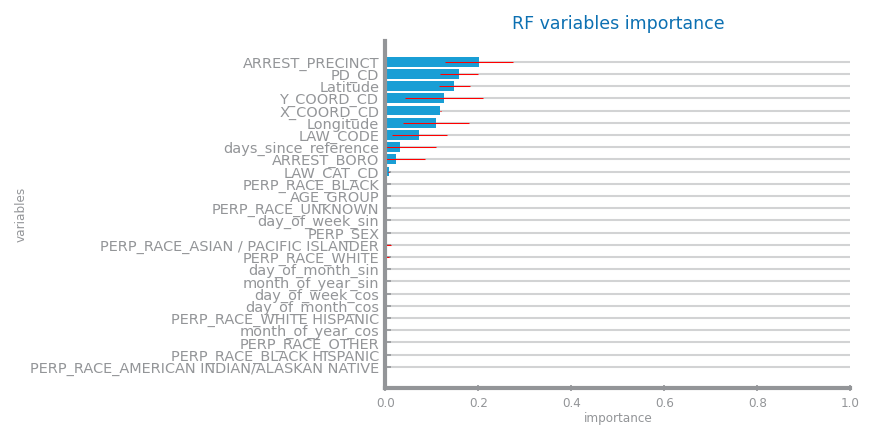

In [9]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

stdevs: list[float] = list(
    std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
)
importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title="RF variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"/home/mina/Documents/portugal/dataScience/Data_science_project/classification/image2/{file_tag}_rf_{eval_metric}_vars_ranking.png")


In [ ]:
d_max: int = params["params"][0]
feat: float = params["params"][1]
nr_estimators: list[int] = [i for i in range(2, 2501, 500)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "accuracy"

for n in nr_estimators:
    clf = RandomForestClassifier(n_estimators=n, max_depth=d_max, max_features=feat)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"RF overfitting study for d={d_max} and f={feat}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"/home/mina/Documents/portugal/dataScience/Data_science_project/classification/image2/{file_tag}_rf_{eval_metric}_overfitting.png")
